# What's Cooking?

Use recipe ingredients to categorize the cuisine

## Agenda

1. Reading in and exploring the data from Kaggle
2. Feature engineering
3. Model evaluation using **`train_test_split`** and **`cross_val_score`**
4. Making predictions for new data
5. Searching for optimal tuning parameters using **`GridSearchCV`**
6. Extracting features from text using **`CountVectorizer`**
7. Chaining steps into a **`Pipeline`**
8. Combining **`GridSearchCV`** with **`Pipeline`**
9. Efficiently search for tuning parameters using **`RandomizedSearchCV`**
10. Adding features to a document-term matrix (using **`FeatureUnion`**)
11. Ensembling models
12. Calculating cuisine similarity

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function

## Part 1: Reading in and exploring the data

In [2]:
import pandas as pd
train = pd.read_json('train.json')
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
train.shape

(39774, 3)

In [4]:
# count the number of null values in each column
train.isnull().sum()

cuisine        0
id             0
ingredients    0
dtype: int64

In [5]:
train.dtypes

cuisine        object
id              int64
ingredients    object
dtype: object

In [6]:
# select row 0, column 'ingredients'
train.loc[0, 'ingredients']

[u'romaine lettuce',
 u'black olives',
 u'grape tomatoes',
 u'garlic',
 u'pepper',
 u'purple onion',
 u'seasoning',
 u'garbanzo beans',
 u'feta cheese crumbles']

In [7]:
# ingredients are stored as a list of strings, not as a string
type(train.loc[0, 'ingredients'])

list

In [8]:
# examine the class distribution
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [9]:
#len(train.cuisine.value_counts())
train.cuisine.nunique()

20

## Part 2: Feature engineering

- Feature engineering is the process through which you create features that **don't natively exist** in the dataset.
- Your goal is to create features that contain the **signal** from the data (with respect to the response value), rather than the **noise**.

### Example: Number of ingredients

In [10]:
# count the number of ingredients in each recipe
train['num_ingredients'] = train.ingredients.apply(len)
train.head()

,cuisine,id,ingredients,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [11]:
# for each cuisine, calculate the mean number of ingredients
train.groupby('cuisine').num_ingredients.mean()

cuisine
brazilian        9.520343
british          9.708955
cajun_creole    12.617076
chinese         11.982791
filipino        10.000000
french           9.817838
greek           10.182128
indian          12.705961
irish            9.299850
italian          9.909033
jamaican        12.214829
japanese         9.735067
korean          11.284337
mexican         10.877446
moroccan        12.909866
russian         10.224949
southern_us      9.634954
spanish         10.423660
thai            12.545809
vietnamese      12.675152
Name: num_ingredients, dtype: float64

In [12]:
# for each cuisine, "describe" the number of ingredients (and unstack into a DataFrame)
train.groupby('cuisine').num_ingredients.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


In [13]:
# allow plots to appear in the notebook
%matplotlib inline

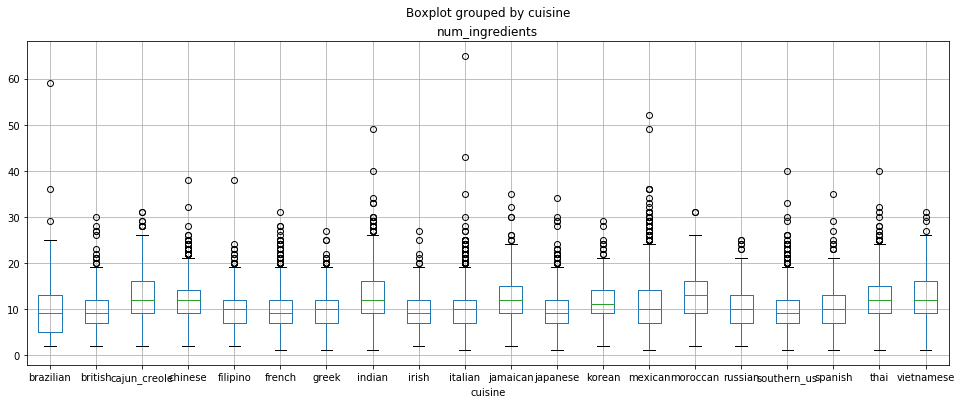

In [14]:
# box plot of number ingredients for each cuisine
train.boxplot('num_ingredients', by='cuisine', figsize=(16, 6))

### Example: Mean length of ingredient names

In [15]:
sample_recipe = train.loc[3, 'ingredients']
print(sample_recipe)

[u'water', u'vegetable oil', u'wheat', u'salt']


In [16]:
import numpy as np

In [17]:
# define a function that calculates the mean string length from a list of strings
def mean_string_length(list_of_strings):
    return np.mean([len(string) for string in list_of_strings])

In [18]:
mean_string_length(sample_recipe)

6.75

In [19]:
# calculate the mean ingredient length for each recipe (two different ways)
train['ingredient_length'] = train.ingredients.apply(mean_string_length)
# train['ingredient_length'] = train.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
train.head()

,cuisine,id,ingredients,num_ingredients,ingredient_length
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,6.750000
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000


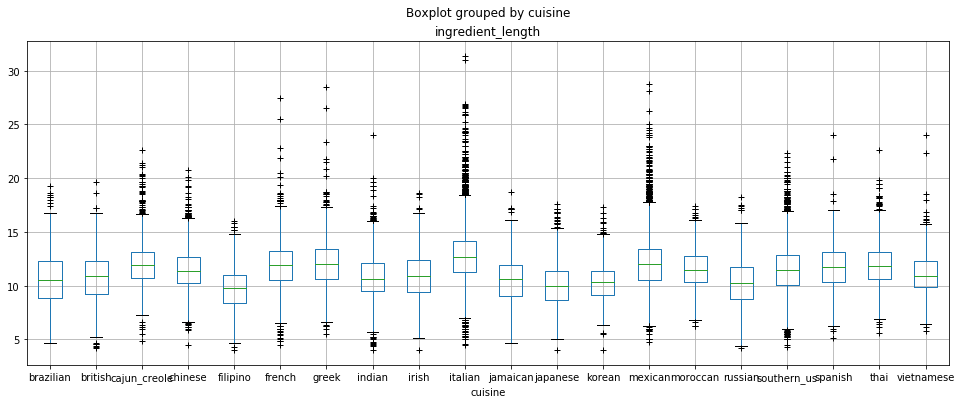

In [20]:
# box plot of mean ingredient length for each cuisine
train.boxplot('ingredient_length', by='cuisine', figsize=(16, 6), sym='+')

In [21]:
# define a function that accepts a DataFrame and adds new features
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    return df

In [22]:
# check that the function works
train = make_features(pd.read_json('train.json'))
train.head()

,cuisine,id,ingredients,num_ingredients,ingredient_length
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,6.750000
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000


## Part 3: Model evaluation using `train_test_split` and `cross_val_score`

- The motivation for model evaluation is that you need a way to **choose between models** (different model types, tuning parameters, and features).
- You use a model evaluation procedure to estimate how well a model will **generalize** to out-of-sample data.
- This requires a model evaluation metric to **quantify** a model's performance.

In [23]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [24]:
print(X.shape)
print(y.shape)

(39774, 2)
(39774L,)


In [25]:
# note: response values are strings (not numbers)
y.values

array([u'greek', u'southern_us', u'filipino', ..., u'irish', u'chinese',
       u'mexican'], dtype=object)

[KNeighborsClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [26]:
# use KNN with K=100
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100)

### Train/test split

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [28]:
# make class predictions for the testing set
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [29]:
# check the classification accuracy of KNN's predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.21932823813354788

### K-fold cross-validation

- Train/test split is **faster and more flexible**
- Cross-validation provides a **more accurate** estimate of out-of-sample performance

In [30]:
# evaluate with 5-fold cross-validation (using X instead of X_train)
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21591924749538957

### Null model

- For **classification** problems, the null model always predicts the most frequent class from the training data.
- For **regression problems**, the null model always predicts the mean of the response value from the training data.
- It can be a useful **baseline model** against which your model is measured.

In [31]:
y_test.shape

(9944L,)

In [32]:
# calculate the null accuracy
y_test.value_counts().head(1) / y_test.shape

italian    0.199216
Name: cuisine, dtype: float64

[DummyClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [33]:
# use DummyClassifier instead
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_pred_class = dumb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.19921560740144811

## Part 4: Making predictions for new data

In [34]:
# read in test.json and add the additional features
new = make_features(pd.read_json('test.json'))
new.head()

,id,ingredients,num_ingredients,ingredient_length
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000


In [35]:
new.shape

(9944, 4)

In [36]:
# create a DataFrame of the relevant columns from the new data
X_new = new[feature_cols]
X_new.head()

,num_ingredients,ingredient_length
0,6,9.333333
1,11,10.272727
2,6,9.666667
3,21,12.000000
4,8,13.000000


In [37]:
X_new.shape

(9944, 2)

In [38]:
# train KNN on ALL of the training data (using X instead of X_train)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [39]:
# make class predictions for the new data
new_pred_class_knn = knn.predict(X_new)
new_pred_class_knn

array([u'mexican', u'southern_us', u'mexican', ..., u'italian', u'mexican',
       u'mexican'], dtype=object)

In [40]:
new_pred_class_knn.shape

(9944L,)

In [41]:
# create a DataFrame that only contains the IDs and predicted classes for the new data
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').head()

,cuisine
id,
18009,mexican
28583,southern_us
41580,mexican
29752,mexican
35687,italian


In [42]:
# create a submission file from that DataFrame (score: 0.21742)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').to_csv('cooking1.csv')

## Part 5: Searching for optimal tuning parameters using `GridSearchCV`

In [43]:
# reminder of the cross-validated accuracy of KNN with K=100
knn = KNeighborsClassifier(n_neighbors=100)
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21591924749538957

[GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
# define a "parameter grid" in which the key is the parameter and the value is a list of options to try
param_grid = {}
param_grid['n_neighbors'] = [100, 200]
param_grid['algorithm'] = ['auto', 'ball_tree']
param_grid

{'algorithm': ['auto', 'ball_tree'], 'n_neighbors': [100, 200]}

In [46]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [47]:
# run the grid search
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [100, 200], 'algorithm': ['auto', 'ball_tree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [48]:
# examine the scores for each parameter option
pd.DataFrame({'mean':grid.cv_results_['mean_test_score'], 
              'std':grid.cv_results_['std_test_score'], 
              'param':grid.cv_results_['params']})

,mean,param,std
0,0.215920,"{u'n_neighbors': 100, u'algorithm': u'auto'}",0.001723
1,0.219490,"{u'n_neighbors': 200, u'algorithm': u'auto'}",0.001810
2,0.216247,"{u'n_neighbors': 100, u'algorithm': u'ball_tree'}",0.002036
3,0.219892,"{u'n_neighbors': 200, u'algorithm': u'ball_tree'}",0.001880


In [49]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.219892392015
{'n_neighbors': 200, 'algorithm': 'ball_tree'}


In [53]:
# try K=200 to 1000 (by 200)
param_grid = {}
param_grid['n_neighbors'] = list(range(200, 1001, 200))
param_grid['algorithm'] = ['auto', 'ball_tree']
param_grid

{'algorithm': ['auto', 'ball_tree'], 'n_neighbors': [200, 400, 600, 800, 1000]}

In [54]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [55]:
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [200, 400, 600, 800, 1000], 'algorithm': ['auto', 'ball_tree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [71]:
df = pd.DataFrame({'mean':grid.cv_results_['mean_test_score'],
                  'params':grid.cv_results_['params']})

In [72]:
df['neighbor'] = df.params.apply(lambda x: x['n_neighbors'])
df['algorithm'] = df.params.apply(lambda x: x['algorithm'])
df

,mean,params,neighbor,algorithm
0,0.219490,"{u'n_neighbors': 200, u'algorithm': u'auto'}",200,auto
1,0.219943,"{u'n_neighbors': 400, u'algorithm': u'auto'}",400,auto
2,0.222130,"{u'n_neighbors': 600, u'algorithm': u'auto'}",600,auto
3,0.222960,"{u'n_neighbors': 800, u'algorithm': u'auto'}",800,auto
4,0.221929,"{u'n_neighbors': 1000, u'algorithm': u'auto'}",1000,auto
5,0.219892,"{u'n_neighbors': 200, u'algorithm': u'ball_tree'}",200,ball_tree
6,0.220395,"{u'n_neighbors': 400, u'algorithm': u'ball_tree'}",400,ball_tree
7,0.221703,"{u'n_neighbors': 600, u'algorithm': u'ball_tree'}",600,ball_tree
8,0.223085,"{u'n_neighbors': 800, u'algorithm': u'ball_tree'}",800,ball_tree
9,0.222155,"{u'n_neighbors': 1000, u'algorithm': u'ball_tr...",1000,ball_tree


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

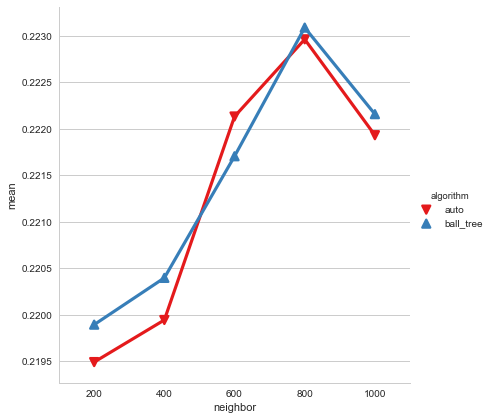

In [119]:
sns.set_style('whitegrid')
sns.factorplot(x='neighbor', y='mean', data=df, hue='algorithm', scale=1, size=6, markers=['v', '^'], palette='Set1')

In [83]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.223085432695
{'n_neighbors': 800, 'algorithm': 'ball_tree'}


## Part 6: Extracting features from text using `CountVectorizer`

In [88]:
# reminder: ingredients are stored as a list of strings, not as a string
train.loc[0, 'ingredients']

[u'romaine lettuce',
 u'black olives',
 u'grape tomatoes',
 u'garlic',
 u'pepper',
 u'purple onion',
 u'seasoning',
 u'garbanzo beans',
 u'feta cheese crumbles']

In [89]:
# convert each list of ingredients into a string
train.ingredients.astype(str)[0]

"[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']"

In [90]:
# update make_features to create a new column 'ingredients_str'
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    df['ingredients_str'] = df.ingredients.astype(str)
    return df

In [91]:
# run make_features and check that it worked
train = make_features(pd.read_json('train.json'))
train.loc[0, 'ingredients_str']

"[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']"

In [92]:
# define X and y
X = train.ingredients_str
y = train.cuisine

In [93]:
# import and instantiate CountVectorizer (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [94]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 3028)

In [95]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

[u'00', u'10', u'100', u'14', u'15', u'25', u'33', u'40', u'43', u'95', u'96', u'abalone', u'abbamele', u'absinthe', u'abura', u'acai', u'accent', u'accompaniment', u'achiote', u'acid', u'acini', u'ackee', u'acorn', u'acting', u'activ', u'active', u'added', u'adobo', u'adzuki', u'agar', u'agave', u'age', u'aged', u'ahi', u'aioli', u'ajinomoto', u'ajwain', u'aka', u'alaskan', u'albacore', u'alcohol', u'ale', u'aleppo', u'alexia', u'alfalfa', u'alfredo', u'all', u'allspice', u'almond', u'almondmilk', u'almonds', u'aloe', u'alphabet', u'alum', u'amaranth', u'amarena', u'amaretti', u'amaretto', u'amba', u'amber', u'amberjack', u'amchur', u'america', u'american', u'aminos', u'ammonium', u'amontillado', u'ampalaya', u'an', u'anaheim', u'anasazi', u'ancho', u'anchovies', u'anchovy', u'and', u'andouille', u'anejo', u'angel', u'anglaise', u'angled', u'angostura', u'angus', u'anise', u'anisette', u'anjou', u'annatto', u'any', u'aonori', u'apple', u'apples', u'applesauce', u'applewood', u'apricot

In [96]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [97]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

[u'a taste of thai rice noodles', u'abalone', u'abbamele', u'absinthe', u'abura age', u'acai juice', u'accent', u'accent seasoning', u'accompaniment', u'achiote', u'achiote paste', u'achiote powder', u'acini di pepe', u'ackee', u'acorn squash', u'active dry yeast', u'adobo', u'adobo all purpose seasoning', u'adobo sauce', u'adobo seasoning', u'adobo style seasoning', u'adzuki beans', u'agar', u'agar agar flakes', u'agave nectar', u'agave tequila', u'aged balsamic vinegar', u'aged cheddar cheese', u'aged gouda', u'aged manchego cheese', u'ahi', u'ahi tuna steaks', u'aioli', u'ajinomoto', u'ajwain', u'aka miso', u'alaskan king crab legs', u'alaskan king salmon', u'albacore', u'albacore tuna in water', u'alcohol', u'ale', u'aleppo', u'aleppo pepper', u'alexia waffle fries', u'alfalfa sprouts', u'alfredo sauce', u'alfredo sauce mix', u'all beef hot dogs', u'all potato purpos', u'all purpose seasoning', u'all purpose unbleached flour', u'allspice', u'allspice berries', u'almond butter', u'a

In [98]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [99]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm, y, cv=5, scoring='accuracy').mean()

0.73012671561980391

**Why is this improper cross-validation?**

- Normally, we split the data into training and testing sets **before** creating the document-term matrix. But since **`cross_val_score`** does the splitting for you, we passed it the feature matrix (**`X_dtm`**) rather than the raw text (**`X`**).
- However, that does not appropriately simulate the real world, in which your out-of-sample data will contain **features that were not seen** during model training.

**What's the solution?**

- We need a way to pass **`X`** (not **`X_dtm`**) to **`cross_val_score`**, and have the feature creation (via **`CountVectorizer`**) occur **within each fold** of cross-validation.
- We will do this by using a **`Pipeline`**.

## Part 7: Chaining steps into a `Pipeline`

In [100]:
# examine the numeric columns of the training data
train.describe()

,id,num_ingredients,ingredient_length
count,39774.000000,39774.000000,39774.000000
mean,24849.536959,10.767713,11.733187
std,14360.035505,4.428978,2.364183
min,0.000000,1.000000,4.000000
25%,12398.250000,8.000000,10.200000
50%,24887.000000,10.000000,11.625000
75%,37328.500000,13.000000,13.117647
max,49717.000000,65.000000,31.400000


In [101]:
train.head()

,cuisine,id,ingredients,num_ingredients,ingredient_length,ingredients_str
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,"[u'romaine lettuce', u'black olives', u'grape ..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,"[u'plain flour', u'ground pepper', u'salt', u'..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333,"[u'eggs', u'pepper', u'salt', u'mayonaise', u'..."
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,6.750000,"[u'water', u'vegetable oil', u'wheat', u'salt']"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000,"[u'black pepper', u'shallots', u'cornflour', u..."


[Imputer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

In [102]:
# define '1' as a missing value and impute a replacement using the median
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=1, strategy='median')

[make_pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [105]:
# create a pipeline of missing value imputation and KNN
from sklearn.pipeline import make_pipeline
knn = KNeighborsClassifier(n_neighbors=800, algorithm='ball_tree')
pipe = make_pipeline(imp, knn)

In [106]:
# examine the pipeline steps
pipe.steps

[('imputer',
  Imputer(axis=0, copy=True, missing_values=1, strategy='median', verbose=0)),
 ('kneighborsclassifier',
  KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=800, p=2,
             weights='uniform'))]

[Pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [107]:
# alternative method for creating the identical pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('imputer', imp), ('kneighborsclassifier', knn)])

In [108]:
# fit and predict using the entire pipeline
pipe.fit(X_train, y_train)
y_pred_class = pipe.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.22495977473853579

### Using a `Pipeline` for proper cross-validation

In [109]:
# create a pipeline of vectorization and Naive Bayes
pipe = make_pipeline(vect, nb)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
          vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

We can now pass **`X`** (instead of **`X_dtm`**) to **`cross_val_score`**, and the vectorization will occur **within each fold** of cross-validation.

In [110]:
# define X and y
X = train.ingredients_str
y = train.cuisine

In [111]:
# X is just a Series of strings
X.head()

0    [u'romaine lettuce', u'black olives', u'grape ...
1    [u'plain flour', u'ground pepper', u'salt', u'...
2    [u'eggs', u'pepper', u'salt', u'mayonaise', u'...
3      [u'water', u'vegetable oil', u'wheat', u'salt']
4    [u'black pepper', u'shallots', u'cornflour', u...
Name: ingredients_str, dtype: object

In [112]:
# cross-validate the entire pipeline
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.73228849337901514

### Making predictions using a `Pipeline`

In [113]:
# fit the pipeline (rather than just the model)
pipe.fit(X, y)

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [114]:
# read in test.json and add the additional features
new = make_features(pd.read_json('test.json'))

In [115]:
# define X_new as a Series of strings
X_new = new.ingredients_str

In [116]:
# use the pipeline to make predictions for the new data
new_pred_class_pipe = pipe.predict(X_new)

In [117]:
# create a submission file (score: 0.73663)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_pipe}).set_index('id').to_csv('cooking2.csv')

## Part 8: Combining `GridSearchCV` with `Pipeline`

- We use **`GridSearchCV`** to locate optimal tuning parameters by performing an "exhaustive grid search" of different parameter combinations, searching for the combination that has the best cross-validated accuracy.
- By passing a **`Pipeline`** to **`GridSearchCV`** (instead of just a model), we can search tuning parameters for both the vectorizer and the model.

In [120]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

['multinomialnb', 'countvectorizer']

In [121]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

In [122]:
# pass the pipeline (instead of the model) to GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [123]:
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"], 'multinomialnb__alpha': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [124]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.747699502187
{'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


## Part 9: Efficiently searching for tuning parameters using `RandomizedSearchCV`

- When there are many parameters to tune, searching all possible combinations of parameter values may be **computationally infeasible**.
- **`RandomizedSearchCV`** searches a sample of the parameter values, and you control the computational "budget".

In [126]:
from sklearn.model_selection import RandomizedSearchCV

In [127]:
# for any continuous parameters, specify a distribution instead of a list of options
import scipy as sp
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['countvectorizer__min_df'] = [1, 2, 3]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__min_df': [1, 2, 3],
 'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x20fb6e48>}

In [128]:
# set a random seed for sp.stats.uniform
np.random.seed(1)

In [132]:
# additional parameters are n_iter (number of searches) and random_state
rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_iter=15, random_state=1)

In [133]:
# time the randomized search
%time rand.fit(X, y)

Wall time: 1min 58s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"], 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020FB6E48>, 'countvectorizer__min_df': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [134]:
print(rand.best_score_)
print(rand.best_params_)

0.751822798813
{'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.085044211369777911, 'countvectorizer__min_df': 1}


### Making predictions for new data

In [135]:
# define X_new as the ingredient text
X_new = new.ingredients_str

In [136]:
# print the best model found by RandomizedSearchCV
rand.best_estimator_

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.085044211369777911, class_prior=None, fit_prior=True))])

In [137]:
# RandomizedSearchCV/GridSearchCV automatically refit the best model with the entire dataset, and can be used to make predictions
new_pred_class_rand = rand.predict(X_new)
new_pred_class_rand

array([u'british', u'southern_us', u'italian', ..., u'italian',
       u'southern_us', u'mexican'], 
      dtype='<U12')

In [138]:
# create a submission file (score: 0.75251)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_rand}).set_index('id').to_csv('cooking3.csv')

## Part 10: Adding features to a document-term matrix (using `FeatureUnion`)

- To do so, we have to learn about transformers, **`FunctionTransformer`**, and **`FeatureUnion`**.

### What are "transformers"?

Transformer objects provide a `transform` method in order to perform **data transformations**. Here are a few examples:

- **`CountVectorizer`**
    - `fit` learns the vocabulary
    - `transform` creates a document-term matrix using the vocabulary
- **`Imputer`**
    - `fit` learns the value to impute
    - `transform` fills in missing entries using the imputation value
- **`StandardScaler`**
    - `fit` learns the mean and scale of each feature
    - `transform` standardizes the features using the mean and scale
- **`HashingVectorizer`**
    - `fit` is not used, and thus it is known as a "stateless" transformer
    - `transform` creates the document-term matrix using a hash of the token

### Converting a function into a transformer

In [139]:
# define a function that accepts a DataFrame returns the manually created features
def get_manual(df):
    return df.loc[:, ['num_ingredients', 'ingredient_length']]

In [140]:
get_manual(train).head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


In [141]:
from sklearn.preprocessing import FunctionTransformer

In [142]:
# create a stateless transformer from the get_manual function
get_manual_ft = FunctionTransformer(get_manual, validate=False)
type(get_manual_ft)

sklearn.preprocessing._function_transformer.FunctionTransformer

In [143]:
# execute the function using the transform method
get_manual_ft.transform(train).head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


In [144]:
# define a function that accepts a DataFrame returns the ingredients string
def get_text(df):
    return df.ingredients_str

In [145]:
# create and test another transformer
get_text_ft = FunctionTransformer(get_text, validate=False)
get_text_ft.transform(train).head()

0    [u'romaine lettuce', u'black olives', u'grape ...
1    [u'plain flour', u'ground pepper', u'salt', u'...
2    [u'eggs', u'pepper', u'salt', u'mayonaise', u'...
3      [u'water', u'vegetable oil', u'wheat', u'salt']
4    [u'black pepper', u'shallots', u'cornflour', u...
Name: ingredients_str, dtype: object

### Combining feature extraction steps

- **`FeatureUnion`** applies a list of transformers in parallel to the input data (not sequentially), then **concatenates the results**.
- This is useful for combining several feature extraction mechanisms into a single transformer.

In [146]:
from sklearn.pipeline import make_union

In [147]:
vect

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)

In [148]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [149]:
# this is identical to a FeatureUnion with just one transformer
union = make_union(vect)
X_dtm = union.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [152]:
# properly combine the transformers into a FeatureUnion
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)
X_dtm_manual = union.fit_transform(train)
X_dtm_manual.shape

(39774, 6252)

### Cross-validation

In [153]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm_manual, y, cv=5, scoring='accuracy').mean()

0.71028951068529533

In [154]:
# create a pipeline of the FeatureUnion and Naive Bayes
pipe = make_pipeline(union, nb)

# properly cross-validate the entire pipeline (and pass it the entire DataFrame)
cross_val_score(pipe, train, y, cv=5, scoring='accuracy').mean()

0.71343183886118777

In [164]:
# duplicate the pipeline structure without using make_pipeline or make_union
from sklearn.pipeline import Pipeline, FeatureUnion
pipe = Pipeline([
    ('featureunion', FeatureUnion([
            ('pipeline', Pipeline([
                    ('functiontransformer', get_text_ft),
                    ('countvectorizer', vect)
                    ])),
            ('functiontransformer', get_manual_ft)
        ])),
    ('multinomialnb', nb)
])

### Grid search of a nested `Pipeline`

In [165]:
# examine the pipeline steps
pipe.steps

[('featureunion', FeatureUnion(n_jobs=1,
         transformer_list=[('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
            func=<function get_text at 0x0000000021B84358>, inv_kw_args=None,
            inverse_func=None, kw_args=None, pass_y=False, validate=False)), ('countvectorizer', CountVectorizer(a...        inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=False))],
         transformer_weights=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [166]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'featureunion__pipeline__countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

In [167]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [168]:
%time grid.fit(train, y)

Wall time: 38.3 s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_text at 0x0000000021B84358>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, v...ormer_weights=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'featureunion__pipeline__countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"], 'multinomialnb__alpha': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [169]:
print(grid.best_score_)
print(grid.best_params_)

0.742671091668
{'featureunion__pipeline__countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


### Continue tuning the model with Grid search, Featureunion and Pipeline

In [170]:
vect = CountVectorizer(token_pattern="'([a-z ]+)'")
nb = MultinomialNB()

In [171]:
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)
pipe = make_pipeline(union, nb)

In [172]:
pipe.steps

[('featureunion', FeatureUnion(n_jobs=1,
         transformer_list=[('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
            func=<function get_text at 0x0000000021B84358>, inv_kw_args=None,
            inverse_func=None, kw_args=None, pass_y=False, validate=False)), ('countvectorizer', CountVectorizer(a...        inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=False))],
         transformer_weights=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [173]:
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__min_df'] = [1, 2]
param_grid['featureunion__pipeline__countvectorizer__max_df'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid['multinomialnb__alpha'] = np.arange(0.01, 0.6, 0.01)
param_grid

{'featureunion__pipeline__countvectorizer__max_df': [0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.6],
 'featureunion__pipeline__countvectorizer__min_df': [1, 2],
 'multinomialnb__alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
         0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
         0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
         0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
         0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
         0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
         0.55,  0.56,  0.57,  0.58,  0.59])}

In [174]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [175]:
train = make_features(pd.read_json('train.json'))
y = train.cuisine

%time grid.fit(train, y)

Wall time: 1h 27min 18s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_text at 0x0000000021B84358>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, v...ormer_weights=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'featureunion__pipeline__countvectorizer__min_df': [1, 2], 'multinomialnb__alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0...,  0.58,  0.59]), 'featureunion__pipeline__countvectorizer__max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
     

In [176]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.751521094182
{'featureunion__pipeline__countvectorizer__min_df': 1, 'multinomialnb__alpha': 0.17000000000000001, 'featureunion__pipeline__countvectorizer__max_df': 0.2}
Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_text at 0x0000000021B84358>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, v...ne)), ('multinomialnb', MultinomialNB(alpha=0.17000000000000001, class_prior=None, fit_prior=True))])


### Make prediction and submit

In [178]:
new = make_features(pd.read_json('test.json'))
new_pred_class = grid.predict(new)
new_pred_class

array([u'british', u'southern_us', u'italian', ..., u'italian',
       u'cajun_creole', u'mexican'], 
      dtype='<U12')

In [179]:
# create a submission file (score: 0.75412)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class}).set_index('id').to_csv('cooking4.csv')

## Part 11: Ensembling models

Rather than combining features into a single feature matrix and training a single model, we can instead create separate models and "ensemble" them.

### What is ensembling?

Ensemble learning (or "ensembling") is the process of combining several predictive models in order to produce a combined model that is **better than any individual model**.

- **Regression:** average the predictions made by the individual models
- **Classification:** let the models "vote" and use the most common prediction, or average the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different "processes", such as:
    - different types of models
    - different features
    - different tuning parameters

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

**Note:** There are also models that have built-in ensembling, such as Random Forests.

### Model 1: KNN model using only manually created features

In [180]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [181]:
# use KNN with K=800
knn = KNeighborsClassifier(n_neighbors=800)

In [182]:
# train KNN on all of the training data
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=800, p=2,
           weights='uniform')

In [183]:
# define X_new as the manually created features
X_new = new[feature_cols]

In [184]:
# calculate predicted probabilities of class membership for the new data
new_pred_prob_knn = knn.predict_proba(X_new)
new_pred_prob_knn.shape

(9944L, 20L)

In [185]:
# print predicted probabilities for the first row only
new_pred_prob_knn[0, :]

array([ 0.02625,  0.0275 ,  0.01375,  0.04375,  0.03375,  0.08   ,
        0.0175 ,  0.075  ,  0.0275 ,  0.135  ,  0.01   ,  0.075  ,
        0.01875,  0.165  ,  0.00875,  0.0125 ,  0.1525 ,  0.025  ,
        0.0275 ,  0.025  ])

In [186]:
# display classes with probabilities
zip(knn.classes_, new_pred_prob_knn[0, :])

[(u'brazilian', 0.026249999999999999),
 (u'british', 0.0275),
 (u'cajun_creole', 0.01375),
 (u'chinese', 0.043749999999999997),
 (u'filipino', 0.033750000000000002),
 (u'french', 0.080000000000000002),
 (u'greek', 0.017500000000000002),
 (u'indian', 0.074999999999999997),
 (u'irish', 0.0275),
 (u'italian', 0.13500000000000001),
 (u'jamaican', 0.01),
 (u'japanese', 0.074999999999999997),
 (u'korean', 0.018749999999999999),
 (u'mexican', 0.16500000000000001),
 (u'moroccan', 0.0087500000000000008),
 (u'russian', 0.012500000000000001),
 (u'southern_us', 0.1525),
 (u'spanish', 0.025000000000000001),
 (u'thai', 0.0275),
 (u'vietnamese', 0.025000000000000001)]

In [187]:
# predicted probabilities will sum to 1 for each row
new_pred_prob_knn[0, :].sum()

1.0

### Model 2: Naive Bayes model using only text features

In [188]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")

# instantiate Multinomial Naive Bayes (with the default parameters)
nb = MultinomialNB()

# create a pipeline of vectorization and Naive Bayes
pipe = make_pipeline(vect, nb)

In [189]:
param_grid = {}
param_grid['countvectorizer__min_df'] = [1, 2, 3]
param_grid['countvectorizer__max_df'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
 'countvectorizer__min_df': [1, 2, 3],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x7295b898>}

In [190]:
# set a random seed for sp.stats.uniform
np.random.seed(1)

# additional parameters are n_iter (number of searches) and random_state
rand = RandomizedSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_iter=20, random_state=1)

In [191]:
# define X and y
X = train.ingredients_str
y = train.cuisine

# time the randomized search
%time rand.fit(X, y)

Wall time: 4min 50s


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000007295B898>, 'countvectorizer__min_df': [1, 2, 3], 'countvectorizer__max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [192]:
# print the best model found by RandomizedSearchCV
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.753985015337
{'multinomialnb__alpha': 0.20445224973151743, 'countvectorizer__min_df': 1, 'countvectorizer__max_df': 0.3}
Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.3, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
        vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.20445224973151743, class_prior=None, fit_prior=True))])


In [193]:
# define X_new as the ingredient text
X_new = new.ingredients_str

# calculate predicted probabilities of class membership for the new data
new_pred_prob_rand = rand.predict_proba(X_new)

# print predicted probabilities for the first row only
new_pred_prob_rand[0, :]

array([  5.97873998e-04,   5.03438294e-01,   4.48610936e-05,
         6.29728084e-05,   3.65345953e-03,   1.28710018e-03,
         4.07586902e-04,   3.06504018e-04,   1.94938948e-01,
         3.55140542e-03,   2.62093823e-04,   4.78289636e-04,
         3.47866711e-06,   8.01621449e-04,   7.60691225e-06,
         3.10381559e-02,   2.58826820e-01,   2.91933434e-04,
         8.52911069e-07,   1.40950875e-07])

### Predict using model 2 along

In [196]:
new_pred_class_rand = rand.predict(X_new)
# create a submission file (score: 0.75392)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_rand}).set_index('id').to_csv('cooking5.csv')

### Ensembling models 1 and 2

In [197]:
# calculate the mean of the predicted probabilities for the first row
(new_pred_prob_knn[0, :] + new_pred_prob_rand[0, :]) / 2

array([ 0.01342394,  0.26546915,  0.00689743,  0.02190649,  0.01870173,
        0.04064355,  0.00895379,  0.03765325,  0.11121947,  0.0692757 ,
        0.00513105,  0.03773914,  0.00937674,  0.08290081,  0.0043788 ,
        0.02176908,  0.20566341,  0.01264597,  0.01375043,  0.01250007])

In [198]:
# calculate the mean of the predicted probabilities for all rows
new_pred_prob = pd.DataFrame((new_pred_prob_knn + new_pred_prob_rand) / 2, columns=knn.classes_)
new_pred_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.013424,0.265469,0.006897,0.021906,0.018702,0.040644,0.008954,0.037653,0.111219,0.069276,0.005131,0.037739,0.009377,0.082901,0.004379,0.021769,0.205663,0.012646,0.013750,0.012500
1,0.008750,0.010559,0.016875,0.045000,0.018127,0.023805,0.015625,0.046250,0.010627,0.070625,0.005626,0.027501,0.021875,0.066875,0.008125,0.008750,0.548756,0.007500,0.025625,0.013125
2,0.012796,0.009380,0.006909,0.020000,0.015003,0.040487,0.009728,0.029375,0.013254,0.417028,0.005626,0.038751,0.007500,0.080628,0.022966,0.008179,0.079376,0.154889,0.015625,0.012501
3,0.003125,0.004375,0.533750,0.038750,0.001875,0.023125,0.006250,0.075625,0.001250,0.051875,0.011875,0.008125,0.003125,0.107500,0.029375,0.001875,0.025000,0.007500,0.038125,0.027500
4,0.001878,0.009827,0.020109,0.021250,0.003125,0.044742,0.017500,0.013750,0.012528,0.641564,0.003751,0.007500,0.003750,0.083129,0.004376,0.003131,0.072333,0.018254,0.014375,0.003125


In [199]:
new_pred_prob.shape

(9944, 20)

In [200]:
# for each row, find the column with the highest predicted probability
new_pred_class = new_pred_prob.apply(np.argmax, axis=1)
new_pred_class.head()

0         british
1     southern_us
2         italian
3    cajun_creole
4         italian
dtype: object

In [201]:
new_pred_class.shape

(9944L,)

In [202]:
# create a submission file (score: 0.75392)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class}).set_index('id').to_csv('cooking6.csv')

## Part 12: Calculating cuisine similarity

In [203]:
# for each cuisine, combine all of the recipes into a single string
cuisine_ingredients = train.groupby('cuisine').ingredients_str.sum()
cuisine_ingredients

cuisine
brazilian       [u'ice cubes', u'club soda', u'white rum', u'l...
british         [u'greek yogurt', u'lemon curd', u'confectione...
cajun_creole    [u'herbs', u'lemon juice', u'fresh tomatoes', ...
chinese         [u'low sodium soy sauce', u'fresh ginger', u'd...
filipino        [u'eggs', u'pepper', u'salt', u'mayonaise', u'...
french          [u'sugar', u'salt', u'fennel bulb', u'water', ...
greek           [u'romaine lettuce', u'black olives', u'grape ...
indian          [u'water', u'vegetable oil', u'wheat', u'salt'...
irish           [u'cooking spray', u'salt', u'black pepper', u...
italian         [u'sugar', u'pistachio nuts', u'white almond b...
jamaican        [u'plain flour', u'sugar', u'butter', u'eggs',...
japanese        [u'sirloin', u'mirin', u'yellow onion', u'low ...
korean          [u'jasmine rice', u'garlic', u'scallions', u's...
mexican         [u'olive oil', u'purple onion', u'fresh pineap...
moroccan        [u'ground cloves', u'whole nutmegs', u'ground ...
ru

In [204]:
# create a document-term matrix from cuisine_ingredients
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
cuisine_dtm = vect.fit_transform(cuisine_ingredients)
cuisine_dtm.shape

(20, 3028)

In [205]:
# calculate the cosine similarity between each cuisine and all other cuisines
from sklearn import metrics
cuisine_similarity = []
for idx in range(cuisine_dtm.shape[0]):
    similarity = metrics.pairwise.linear_kernel(cuisine_dtm[idx, :], cuisine_dtm).flatten()
    cuisine_similarity.append(similarity)

In [207]:
# convert the results to a DataFrame
cuisine_list = cuisine_ingredients.index
cuisine_similarity = pd.DataFrame(cuisine_similarity, index=cuisine_list, columns=cuisine_list)
cuisine_similarity

cuisine,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
cuisine,,,,,,,,,,,,,,,,,,,,
brazilian,1.000000,0.660156,0.742322,0.580757,0.769215,0.755767,0.695686,0.687244,0.665677,0.740519,0.778320,0.555601,0.571439,0.743713,0.669002,0.705931,0.743146,0.807689,0.685539,0.653800
british,0.660156,1.000000,0.591167,0.467593,0.631277,0.859299,0.562693,0.560318,0.926662,0.632588,0.661978,0.508248,0.447121,0.560398,0.543230,0.909555,0.911177,0.603975,0.445473,0.478860
cajun_creole,0.742322,0.591167,1.000000,0.605581,0.746149,0.708263,0.688395,0.618938,0.635172,0.738158,0.780895,0.532397,0.578644,0.724866,0.649826,0.657667,0.747479,0.803631,0.590103,0.605223
chinese,0.580757,0.467593,0.605581,1.000000,0.839802,0.540009,0.496090,0.553515,0.460728,0.555503,0.635953,0.835586,0.866827,0.561824,0.505653,0.521739,0.558511,0.603523,0.755814,0.817003
filipino,0.769215,0.631277,0.746149,0.839802,1.000000,0.682372,0.607433,0.655896,0.640979,0.670621,0.792723,0.748554,0.782623,0.678285,0.614970,0.696845,0.720363,0.727401,0.741510,0.806831
french,0.755767,0.859299,0.708263,0.540009,0.682372,1.000000,0.759303,0.624355,0.836959,0.834680,0.722627,0.539835,0.501789,0.666329,0.684843,0.880922,0.861419,0.816989,0.547923,0.570485
greek,0.695686,0.562693,0.688395,0.496090,0.607433,0.759303,1.000000,0.640285,0.583655,0.859268,0.681278,0.469471,0.479832,0.696638,0.769405,0.649402,0.641235,0.837435,0.519005,0.538680
indian,0.687244,0.560318,0.618938,0.553515,0.655896,0.624355,0.640285,1.000000,0.577297,0.616204,0.734893,0.567991,0.538822,0.708576,0.795278,0.607321,0.617247,0.678842,0.627444,0.605132
irish,0.665677,0.926662,0.635172,0.460728,0.640979,0.836959,0.583655,0.577297,1.000000,0.649873,0.680880,0.494742,0.458775,0.591703,0.563278,0.892391,0.902821,0.630912,0.449910,0.481697


In [208]:
cuisine_similarity.shape

(20, 20)

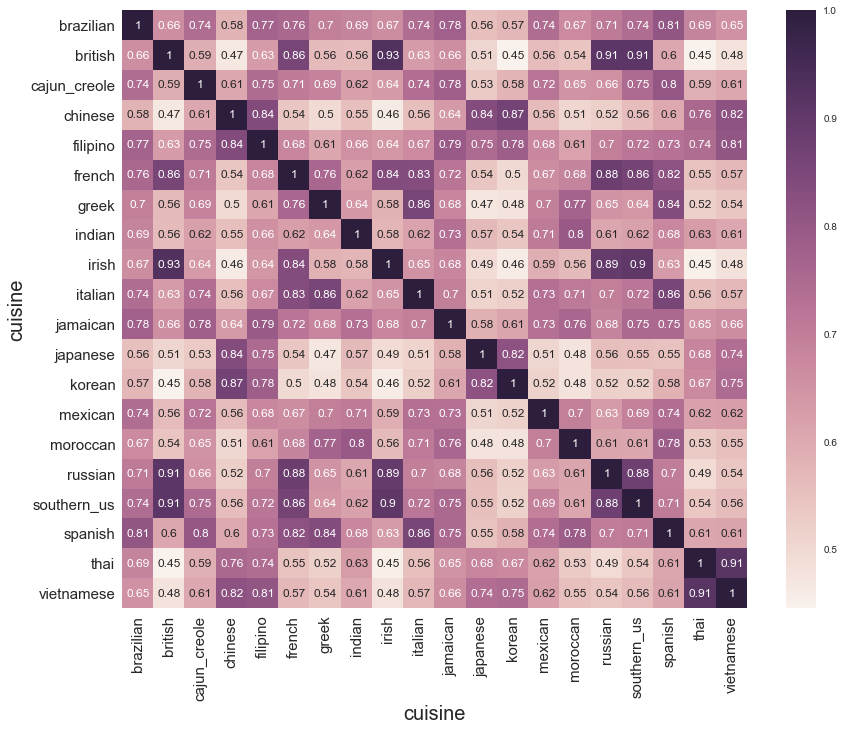

In [242]:
# display the similarities as a heatmap
plt.figure(figsize=(14, 11))
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
sns.heatmap(cuisine_similarity, annot=True)

### Some findings:
British cuisine is similar to french, irish, rissian and southern_us food, while chinese food is similar to its neighbors' food like filipino, japanese, korean ones. Likewise, thai is similar to vietnamese. Also italian is similar to its surrounding countries' food such as french, greek and spanish. This is expected result.